In [23]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.preprocessing import StandardScaler

# Домашняя работа: деревья решений

В этой домашней работе вам предстоит научиться предсказывать цены товаров из маркетплейса Azamon.

Требования к домашней работе:
- Во всех графиках должны быть подписи через title, legend, etc.
- Во время обучения моделей проверяйте, что у вас не текут данные. Обычно это позитивно влияет на качество модели на тесте, но негативно влияет на оценку 🌚
- Если вы сдаете работу в Google Colaboratory, убедитесь, что ваша тетрадка доступна по ссылке. Если в итоге по каким-то причинам тетрадка не будет открываться у преподавателя, задание не будет засчитано
- Использование мемов допускается, но необходимо соблюдать меру. Несодержательная работа, состоящая только из мемов, получает 0 баллов.

# Загрузка и подготовка данных

In [24]:
!gdown 18PVwZWFbpRbEHW-Hc8R0DUTl9CF1aQa0 -O data.csv

Downloading...
From: https://drive.google.com/uc?id=18PVwZWFbpRbEHW-Hc8R0DUTl9CF1aQa0
To: /content/data.csv
100% 30.0M/30.0M [00:00<00:00, 74.0MB/s]


In [25]:
df = pd.read_csv('data.csv', thousands=',').drop(columns=[
    'product_name',
    'index',
    'uniq_id',
    'customers_who_bought_this_item_also_bought',
    'items_customers_buy_after_viewing_this_item',
    'sellers',
    'description', # text
    'product_information', # text
    'product_description', # text
    'customer_questions_and_answers', # text
    'customer_reviews', # text
])

In [26]:
df.columns

Index(['manufacturer', 'price', 'number_available_in_stock',
       'number_of_reviews', 'number_of_answered_questions',
       'average_review_rating', 'amazon_category_and_sub_category'],
      dtype='object')

In [27]:
df

,manufacturer,price,number_available_in_stock,number_of_reviews,number_of_answered_questions,average_review_rating,amazon_category_and_sub_category
0,Hornby,£3.42,5 new,15.0,1.0,4.9 out of 5 stars,Hobbies > Model Trains & Railway Sets > Rail V...
1,FunkyBuys,£16.99,NaN,2.0,1.0,4.5 out of 5 stars,Hobbies > Model Trains & Railway Sets > Rail V...
2,ccf,£9.99,2 new,17.0,2.0,3.9 out of 5 stars,Hobbies > Model Trains & Railway Sets > Rail V...
3,Hornby,£39.99,NaN,1.0,2.0,5.0 out of 5 stars,Hobbies > Model Trains & Railway Sets > Rail V...
4,Hornby,£32.19,NaN,3.0,2.0,4.7 out of 5 stars,Hobbies > Model Trains & Railway Sets > Rail V...
...,...,...,...,...,...,...,...
8542,Mattel,£22.95,5 new,3.0,3.0,5.0 out of 5 stars,Hobbies > Collectible Figures & Memorabilia > ...
8543,Star Wars,£39.99,NaN,1.0,3.0,4.0 out of 5 stars,Characters & Brands > Star Wars > Toys
8544,Olde Scotland Yard Ltd.,£43.99,3 new,1.0,3.0,5.0 out of 5 stars,Novelty & Special Use > Novelty > Accessories ...
8545,DC Comics,£49.81,3 new,1.0,3.0,5.0 out of 5 stars,Hobbies > Collectible Figures & Memorabilia > ...


In [28]:
X, y = df.drop(columns=['price']), df.price

## Очистка данных (1 балл)

Посмотрите на признаки. Есть ли в них пропуски? Какое соотношение между NaN'ами и общим количеством данных? Есть ли смысл выкидывать какие-либо данные из этого датасета?

usefull link: https://www.dmitrymakarov.ru/data-analysis/nan-06/, https://www.dmitrymakarov.ru/data-analysis/nan-06-2/

In [29]:
nans = df.isna().sum() # => пропуски есть
nans

manufacturer                           5
price                                  0
number_available_in_stock           2211
number_of_reviews                     15
number_of_answered_questions         673
average_review_rating                 15
amazon_category_and_sub_category     550
dtype: int64

In [30]:
nans / df.shape[0] # процент пропусков в данных

manufacturer                        0.000585
price                               0.000000
number_available_in_stock           0.258687
number_of_reviews                   0.001755
number_of_answered_questions        0.078741
average_review_rating               0.001755
amazon_category_and_sub_category    0.064350
dtype: float64

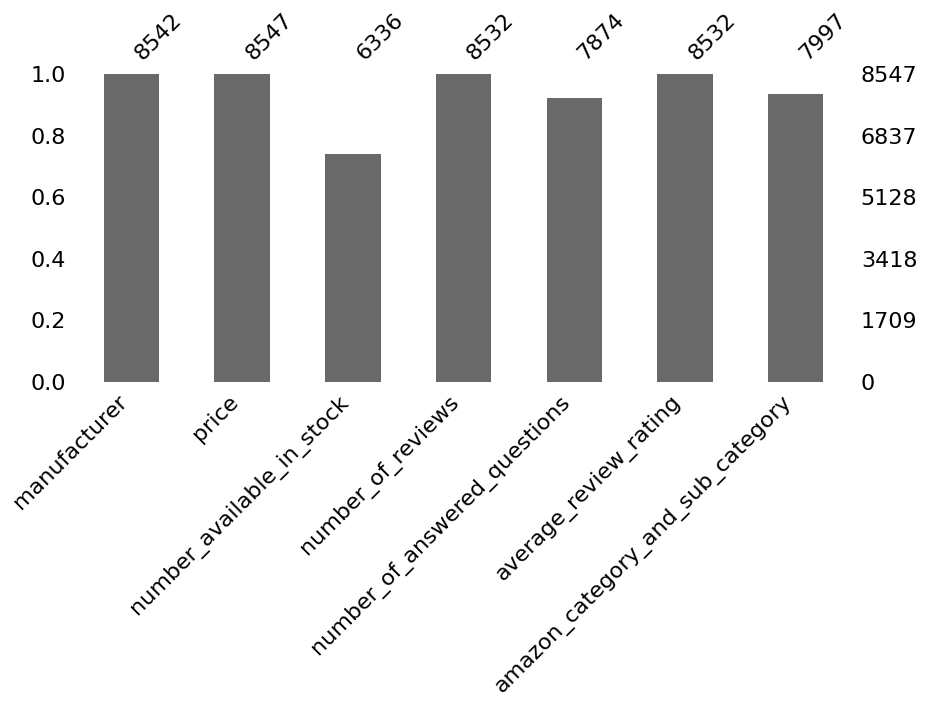

In [31]:
import missingno as msno

# визаулизируем количество не пропущенных значений
# в виде гистограммы для каждого признака

msno.bar(df, figsize=(10, 4));

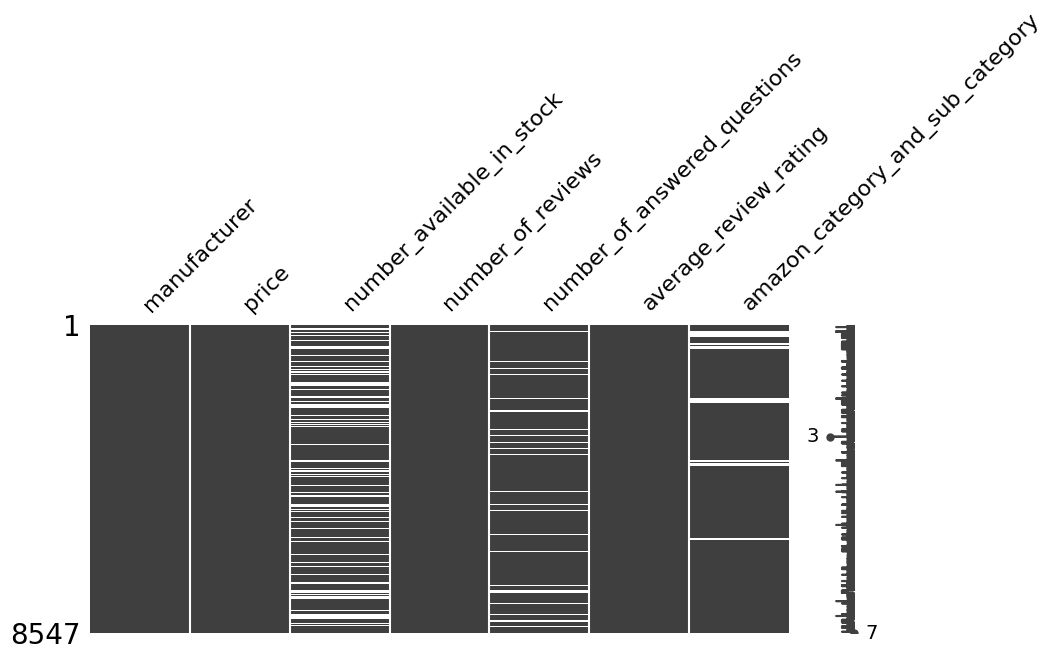

In [32]:
# визаулизируем пропуски для каждого признака
msno.matrix(df, figsize=(10, 4));

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8547 entries, 0 to 8546
Data columns (total 7 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   manufacturer                      8542 non-null   object 
 1   price                             8547 non-null   object 
 2   number_available_in_stock         6336 non-null   object 
 3   number_of_reviews                 8532 non-null   float64
 4   number_of_answered_questions      7874 non-null   float64
 5   average_review_rating             8532 non-null   object 
 6   amazon_category_and_sub_category  7997 non-null   object 
dtypes: float64(2), object(5)
memory usage: 467.5+ KB


Можно попробовать отбросить признак `number_available_in_stock`, так как для него пропусков около 26% от всех данных.

In [34]:
X.drop(columns=['number_available_in_stock'], inplace=True)

In [35]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.65, random_state=42)

## Подготовка данных (3 балла)

Обработайте признаки. Выполните кодирование категориальных признаков, заполните пропуски в числовых признаках. Обратите внимание, что в датасете есть признак, который разбивается на несколько подпризнаков. Что это за признак? Закодируйте и его.

Дополнительные вопросы (+ 1 балл):
- Какие из признаков в этом датасете лучше кодировать через ordinal encoding?
- Какие из признаков допустимо кодировать через one-hot?

Прим.: суммарно за эту секцию можно получить до 4 баллов.

**Ответ:**

`amazon_category_and_sub_category` разбивается на несколько подпризнаков, так как это признак обозначает категории и подкатегории. Этот признак разделим на два и каждый из них закодируем, используя ohe. (Update: пробовал так сделать, но происходит сильный рост ошибок, видимо, из-за сильной вариативности подкатегории, поэтому лучше оставить от этого признака только категорию)

Можно использовать ordinal encoding для признака `average_review_rating`, так как он оценивает рейтинг фильма по пятибальной шкале. То есть можно просто из строки достать эту цифру для каждоого значения этого признака и не использовать готовый метод из sklearn.

Из логики понятно, что лучше использовать ohe для тех признаков, которые не сильно увеличат размерность матрицы объектов (например, количество уникальных элеметов для `manufacturer` 1824, что очень много (это около терти обучающего датасета...)); поэтому его лучше закодировать, используя, label encoding

usefull link: https://towardsdatascience.com/all-about-categorical-variable-encoding-305f3361fd02

In [36]:
# так как мы используем регрессию, то переведем целевую переменную в число
y_train = y_train.apply(lambda x: float(x[1:].replace(',', ''))).values
y_test = y_test.apply(lambda x: float(x[1:].replace(',', ''))).values

In [37]:
def stars(x):
    if pd.isna(x):
        return np.nan
    num = x.split(' ')[0]
    return float(num)

X_train['average_review_rating'] = X_train['average_review_rating'].apply(stars)
X_test['average_review_rating'] = X_test['average_review_rating'].apply(stars)

In [38]:
# Пропуски в рейтинге фильмов, количестве ответов на вопросы, количестве просмотров заполним средним значением по данному признаку

mean_arr = X_train['average_review_rating'].mean()
X_train['average_review_rating'] = X_train['average_review_rating'].fillna(mean_arr)
X_test['average_review_rating'] = X_test['average_review_rating'].fillna(mean_arr)

mean_noaq = X_train['number_of_answered_questions'].median()
X_train['number_of_answered_questions'] = X_train['number_of_answered_questions'].fillna(mean_noaq)
X_test['number_of_answered_questions'] = X_test['number_of_answered_questions'].fillna(mean_noaq)

mean_n_o_r = np.median(X_train[~X_train['number_of_reviews'].isna()]['number_of_reviews'].astype(int).values)
X_train['number_of_reviews'] = X_train['number_of_reviews'].fillna(mean_n_o_r)
X_test['number_of_reviews'] = X_test['number_of_reviews'].fillna(mean_n_o_r)

X_train['number_of_reviews'] = X_train['number_of_reviews'].apply(pd.to_numeric)
X_test['number_of_reviews'] = X_test['number_of_reviews'].apply(pd.to_numeric)

In [39]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5555 entries, 6253 to 7270
Data columns (total 5 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   manufacturer                      5551 non-null   object 
 1   number_of_reviews                 5555 non-null   float64
 2   number_of_answered_questions      5555 non-null   float64
 3   average_review_rating             5555 non-null   float64
 4   amazon_category_and_sub_category  5198 non-null   object 
dtypes: float64(3), object(2)
memory usage: 260.4+ KB


In [40]:
X_train

,manufacturer,number_of_reviews,number_of_answered_questions,average_review_rating,amazon_category_and_sub_category
6253,Air Storm,4.0,1.0,5.0,Sports Toys & Outdoor > Target Games
344,Q-Workshop,4.0,1.0,4.8,Games > Dice & Dice Games
7219,Hornby,1.0,1.0,5.0,Die-Cast & Toy Vehicles > Toy Vehicles & Acces...
7724,Disney,1.0,1.0,5.0,Characters & Brands > Disney > Toys
3125,Tamiya,1.0,1.0,5.0,Hobbies > Model Building Kits > Tanks
...,...,...,...,...,...
5734,C. Kreul,22.0,1.0,4.8,Arts & Crafts > Colouring Pens & Markers
5191,Black Butler,4.0,1.0,4.5,Figures & Playsets > Accessories
5390,The Expressions Factory,2.0,1.0,4.0,"Party Supplies > Banners, Stickers & Confetti ..."
860,Playmobil,32.0,1.0,4.8,Figures & Playsets > Science Fiction & Fantasy


In [18]:
def cat(x):
    if pd.isna(x):
        return np.nan
    cat = (x.split('>')[0]).strip()
    return cat

X_train['amazon_category'] = X_train['amazon_category_and_sub_category'].apply(cat)
X_test['amazon_category'] = X_test['amazon_category_and_sub_category'].apply(cat)

In [ ]:
# def sub_cat(x):
#     if pd.isna(x):
#         return np.nan
#     cat = (x.split('>')[1]).strip()
#     return cat

# X_train['amazon_sub_category'] = X_train['amazon_category_and_sub_category'].apply(sub_cat)
# X_test['amazon_sub_category'] = X_test['amazon_category_and_sub_category'].apply(sub_cat)

In [19]:
X_train.drop(columns=['amazon_category_and_sub_category'], inplace=True)
X_test.drop(columns=['amazon_category_and_sub_category'], inplace=True)

In [43]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5555 entries, 6253 to 7270
Data columns (total 5 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   manufacturer                      5555 non-null   object 
 1   number_of_reviews                 5555 non-null   float64
 2   number_of_answered_questions      5555 non-null   float64
 3   average_review_rating             5555 non-null   float64
 4   amazon_category_and_sub_category  5555 non-null   object 
dtypes: float64(3), object(2)
memory usage: 260.4+ KB


In [42]:
# for next hw for catboost section
# freq_ac = X_train['amazon_category_and_sub_category'].value_counts().index[0]
# X_train['amazon_category_and_sub_category'] = X_train['amazon_category_and_sub_category'].fillna(freq_ac)
# X_test['amazon_category_and_sub_category'] = X_test['amazon_category_and_sub_category'].fillna(freq_ac)

In [ ]:
# Заполним оставшиеся пропуски самой частой категорией
freq_man = X_train['manufacturer'].value_counts().index[0]
X_train['manufacturer'] = X_train['manufacturer'].fillna(freq_man)
X_test['manufacturer'] = X_test['manufacturer'].fillna(freq_man)

freq_ac = X_train['amazon_category'].value_counts().index[0]
X_train['amazon_category'] = X_train['amazon_category'].fillna(freq_ac)
X_test['amazon_category'] = X_test['amazon_category'].fillna(freq_ac)

# freq_asc = X_train['amazon_sub_category'].value_counts().index[0]
# X_train['amazon_sub_category'] = X_train['amazon_sub_category'].fillna(freq_asc)
# X_test['amazon_sub_category'] = X_test['amazon_sub_category'].fillna(freq_asc)

In [22]:
X_train

,manufacturer,number_of_reviews,number_of_answered_questions,average_review_rating,amazon_category
6253,Air Storm,4.0,1.0,5.0,Sports Toys & Outdoor
344,Q-Workshop,4.0,1.0,4.8,Games
7219,Hornby,1.0,1.0,5.0,Die-Cast & Toy Vehicles
7724,Disney,1.0,1.0,5.0,Characters & Brands
3125,Tamiya,1.0,1.0,5.0,Hobbies
...,...,...,...,...,...
5734,C. Kreul,22.0,1.0,4.8,Arts & Crafts
5191,Black Butler,4.0,1.0,4.5,Figures & Playsets
5390,The Expressions Factory,2.0,1.0,4.0,Party Supplies
860,Playmobil,32.0,1.0,4.8,Figures & Playsets


In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5555 entries, 6253 to 7270
Data columns (total 5 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   manufacturer                  5555 non-null   object 
 1   number_of_reviews             5555 non-null   float64
 2   number_of_answered_questions  5555 non-null   float64
 3   average_review_rating         5555 non-null   float64
 4   amazon_category               5555 non-null   object 
dtypes: float64(3), object(2)
memory usage: 260.4+ KB


In [ ]:
X_train.isna().sum() # всё, пропусков больше нет

manufacturer                    0
number_of_reviews               0
number_of_answered_questions    0
average_review_rating           0
amazon_category                 0
dtype: int64

In [ ]:
ohe = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='infrequent_if_exist')
# df_c_sc_train = ohe.fit_transform(X_train[['amazon_category', 'amazon_sub_category']])
df_c_sc_train = ohe.fit_transform(X_train[['amazon_category']])
df_c_sc_train = pd.DataFrame(df_c_sc_train, columns=ohe.get_feature_names_out())

# df_c_sc_test = ohe.transform(X_test[['amazon_category', 'amazon_sub_category']])
df_c_sc_test = ohe.transform(X_test[['amazon_category']])
df_c_sc_test = pd.DataFrame(df_c_sc_test, columns=ohe.get_feature_names_out())


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [ ]:
# X_train.drop(columns=['amazon_category', 'amazon_sub_category'], inplace=True)
X_train.drop(columns=['amazon_category'], inplace=True)
X_train = pd.concat([X_train.reset_index(drop=True), df_c_sc_train], axis=1)

# X_test.drop(columns=['amazon_category', 'amazon_sub_category'], inplace=True)
X_test.drop(columns=['amazon_category'], inplace=True)
X_test = pd.concat([X_test.reset_index(drop=True), df_c_sc_test], axis=1)

In [ ]:
X_train

,manufacturer,number_of_reviews,number_of_answered_questions,average_review_rating,amazon_category_Baby & Toddler Toys,amazon_category_Bags,amazon_category_Bedding & Linens,amazon_category_Camping & Hiking,amazon_category_Characters & Brands,amazon_category_Cooking & Dining,...,amazon_category_Office Supplies,amazon_category_Party Supplies,"amazon_category_Pens, Pencils & Writing Supplies",amazon_category_Pretend Play,amazon_category_Puppets & Puppet Theatres,amazon_category_Sex & Sensuality,amazon_category_Sports Toys & Outdoor,"amazon_category_Sweets, Chocolate & Gum",amazon_category_Women,amazon_category_Worlds Apart
0,Air Storm,4.0,1.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,Q-Workshop,4.0,1.0,4.8,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Hornby,1.0,1.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Disney,1.0,1.0,5.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Tamiya,1.0,1.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5550,C. Kreul,22.0,1.0,4.8,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5551,Black Butler,4.0,1.0,4.5,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5552,The Expressions Factory,2.0,1.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5553,Playmobil,32.0,1.0,4.8,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# may be use this: https://stackoverflow.com/questions/21057621/sklearn-labelencoder-with-never-seen-before-values/48169252#48169252
# признак manufacturer закодируем просто числами, причем для всех новых категорий (которых не было в трейне) будем присваивать лейбл 0

uniq = X_train['manufacturer'].unique() 
labels = dict(zip(uniq, range(1, len(uniq) + 1)))
X_train['manufacturer'] = X_train['manufacturer'].map(labels)

X_test['manufacturer'] = X_test['manufacturer'].apply(lambda x: labels[x] if x in labels else 0)

In [ ]:
X_train

,manufacturer,number_of_reviews,number_of_answered_questions,average_review_rating,amazon_category_Baby & Toddler Toys,amazon_category_Bags,amazon_category_Bedding & Linens,amazon_category_Camping & Hiking,amazon_category_Characters & Brands,amazon_category_Cooking & Dining,...,amazon_category_Office Supplies,amazon_category_Party Supplies,"amazon_category_Pens, Pencils & Writing Supplies",amazon_category_Pretend Play,amazon_category_Puppets & Puppet Theatres,amazon_category_Sex & Sensuality,amazon_category_Sports Toys & Outdoor,"amazon_category_Sweets, Chocolate & Gum",amazon_category_Women,amazon_category_Worlds Apart
0,1,4.0,1.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,2,4.0,1.0,4.8,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,1.0,1.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,1.0,1.0,5.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,1.0,1.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5550,500,22.0,1.0,4.8,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5551,1822,4.0,1.0,4.5,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5552,1823,2.0,1.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5553,177,32.0,1.0,4.8,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
X_test

,manufacturer,number_of_reviews,number_of_answered_questions,average_review_rating,amazon_category_Baby & Toddler Toys,amazon_category_Bags,amazon_category_Bedding & Linens,amazon_category_Camping & Hiking,amazon_category_Characters & Brands,amazon_category_Cooking & Dining,...,amazon_category_Office Supplies,amazon_category_Party Supplies,"amazon_category_Pens, Pencils & Writing Supplies",amazon_category_Pretend Play,amazon_category_Puppets & Puppet Theatres,amazon_category_Sex & Sensuality,amazon_category_Sports Toys & Outdoor,"amazon_category_Sweets, Chocolate & Gum",amazon_category_Women,amazon_category_Worlds Apart
0,0,1.0,1.0,4.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,651,1.0,1.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,82,4.0,1.0,4.5,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,125,81.0,1.0,4.7,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,26,1.0,1.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2987,43,3.0,1.0,4.7,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2988,580,1.0,3.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2989,848,86.0,1.0,4.4,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2990,289,241.0,1.0,4.8,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [44]:
#@title For next hw
# X_train['split'] = 'Train'
# X_test['split'] = 'Test'
# X_train['y'] = y_train
# X_test['y'] = y_test
# df = pd.concat([X_train.reset_index(drop=True), X_test.reset_index(drop=True)], axis=0)
# df.to_csv('data_and_catf.csv', index=False)

In [ ]:
X_train.isna().sum().unique(), X_test.isna().sum().unique()

(array([0]), array([0]))

In [ ]:
X_train.dtypes.unique(), X_test.dtypes.unique() # => все признаки числовые

(array([dtype('int64'), dtype('float64')], dtype=object),
 array([dtype('int64'), dtype('float64')], dtype=object))

In [ ]:
# нормализуем признаки
scale = StandardScaler()
X_train = scale.fit_transform(X_train)
X_test = scale.transform(X_test)

In [ ]:
# X_train, X_test = X_train.values, X_test.values

# Обучение модели (3 балла)

## Бейзлайн

Обучите базовую модель. Для этого используйте `sklearn.dummy.DummyRegressor`. Какое качество она показывает на тесте? Посчитайте MSE, RMSE.

In [ ]:
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error, r2_score


dummy = DummyRegressor()
dummy.fit(X_train, y_train)

DummyRegressor()

In [ ]:
y_pred_test = dummy.predict(X_test)

print(f'Test MSE: {mean_squared_error(y_test, y_pred_test)}')
print(f'Test RMSE: {mean_squared_error(y_test, y_pred_test, squared=False)}')
print(f'R2 score: {r2_score(y_test, y_pred_test)}')

Test MSE: 1504.8256721617697
Test RMSE: 38.79208259634651
R2 score: -5.555076671881487e-05


## Дерево решений

Обучите регрессионное дерево решений, проверьте качество этой модели на тестовой выборке. Улучшилось ли качество по сравнению с базовой моделью? Оцените r2_score обученной модели.


In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, mean_squared_error as mse

In [ ]:
tree = DecisionTreeRegressor()
tree.fit(X_train, y_train)

y_pred_test = tree.predict(X_test)

print(f'Test MSE: {mean_squared_error(y_test, y_pred_test)}')
print(f'Test RMSE: {mean_squared_error(y_test, y_pred_test, squared=False)}')
print(f'R2 score: {r2_score(y_test, y_pred_test)}')

Test MSE: 2079.781444468704
Test RMSE: 45.60462086750316
R2 score: -0.3821514454459425


Как видно по метрикам вторая модель даёт результат хуже чем базовая (если не настраивать гиперпараметры) и как видно по r2_score не очень сильно отличается от константного предсказания средним.

## Линейная регрессия

Попробуйте обучить линейную регрессию с параметрами по умолчанию. Оцените r2_score на тестовой выборке. Сравните качество с деревом решений. 

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred_test = lr.predict(X_test)

print(f'Test MSE: {mean_squared_error(y_test, y_pred_test)}')
print(f'Test RMSE: {mean_squared_error(y_test, y_pred_test, squared=False)}')
print(f'R2 score: {r2_score(y_test, y_pred_test)}')

Test MSE: 1428.7963492738445
Test RMSE: 37.79942260503253
R2 score: 0.05047093066011521


Выдно, что для гиперпараметров по умолчанию линейная регрессия чуть-чуть хуже, чем константная модель по среднему. Качество для линейной регрессии лучше, чем у дерева решений.

# Гиперпараметры (2 балла)

Переберите несколько гиперпараметров (не более двух-трёх). Обратите внимание, как эти параметры влияют на ошибку модели на тестовой выборке. Постройте для глубины дерева график переобучения (fitting curve) аналогичный тому, что мы строили на занятии. Найдите глубину дерева, начиная с которой модель начинает переобучаться.

In [ ]:
import seaborn as sns


def plot_fitting_curve(model, parameter: str, values: list, X_train, X_test, y_train, y_test, *model_args, draw=True):
    train_curve = []
    test_curve = []
    for value in values:
        model_ = model(*model_args, **{parameter: value})
        model_.fit(X_train, y_train)
        y_pred_train, y_pred_test = model_.predict(X_train), model_.predict(X_test)
        train_curve.append(mse(y_train, y_pred_train))
        test_curve.append(mse(y_test, y_pred_test))
    
    data = pd.DataFrame({f'{parameter}': 2 * values,
            'MSE': train_curve + test_curve,
            'Labels': ['Train'] * len(train_curve) + ['Test'] * len(test_curve)})

    if draw:
        sns.lineplot(data, x=f'{parameter}', y='MSE', hue='Labels')
    return data

Будем перебирать различные гиперпарметры для трех моделей регрессии: Dummy Regressor, Desicion Tree Regressor и Linear Regression.

## Dummy Regressor

In [ ]:
# для среднего предсказания

dummy = DummyRegressor(strategy='mean')
dummy.fit(X_train, y_train)

y_pred_test = dummy.predict(X_test)

print(f'Test MSE: {mean_squared_error(y_test, y_pred_test)}')
print(f'Test RMSE: {mean_squared_error(y_test, y_pred_test, squared=False)}')
print(f'R2 score: {r2_score(y_test, y_pred_test)}')

Test MSE: 1504.8256721617697
Test RMSE: 38.79208259634651
R2 score: -5.555076671881487e-05


In [ ]:
# для квантильной стратегии предсказания

quants = np.linspace(0, 0.9, 100, endpoint=False)

test_mse = []
test_rmse = []
r2_score_ = []
for q in quants:
    dummy = DummyRegressor(strategy='quantile', quantile=q)
    dummy.fit(X_train, y_train)
    y_pred_test = dummy.predict(X_test)
    test_mse.append(mean_squared_error(y_test, y_pred_test))
    test_rmse.append(mean_squared_error(y_test, y_pred_test, squared=False))
    r2_score_.append(r2_score(y_test, y_pred_test))

data = pd.DataFrame({'quantile': quants, 'test_mse': test_mse, 'test_rmse': test_rmse, 'r2_score': r2_score_})
data

,quantile,test_mse,test_rmse,r2_score
0,0.000,1922.098987,43.841749,-0.277361
1,0.009,1883.017930,43.393755,-0.251389
2,0.018,1876.434063,43.317826,-0.247014
3,0.027,1871.438341,43.260124,-0.243694
4,0.036,1863.839839,43.172211,-0.238644
...,...,...,...,...
95,0.855,1596.085694,39.951041,-0.060704
96,0.864,1638.160410,40.474194,-0.088665
97,0.873,1696.997644,41.194631,-0.127766
98,0.882,1717.487795,41.442584,-0.141384


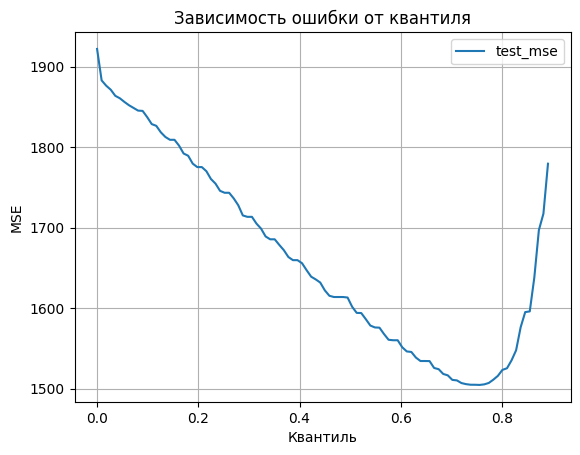

In [ ]:
# то же самое, но на графике

plt.plot(quants, test_mse, label='test_mse')
plt.xlabel('Квантиль')
plt.ylabel('MSE')
plt.title('Зависимость ошибки от квантиля')
plt.legend()
plt.grid()
plt.show()

In [ ]:
data[data['test_mse'] == min(data['test_mse'])]

# видно, что для константного предсказания наименьшую ошибку будет иметь квантиль 0.756

,quantile,test_mse,test_rmse,r2_score
84,0.756,1504.742231,38.791007,-9.883030e-08


## Decision Tree Regressor

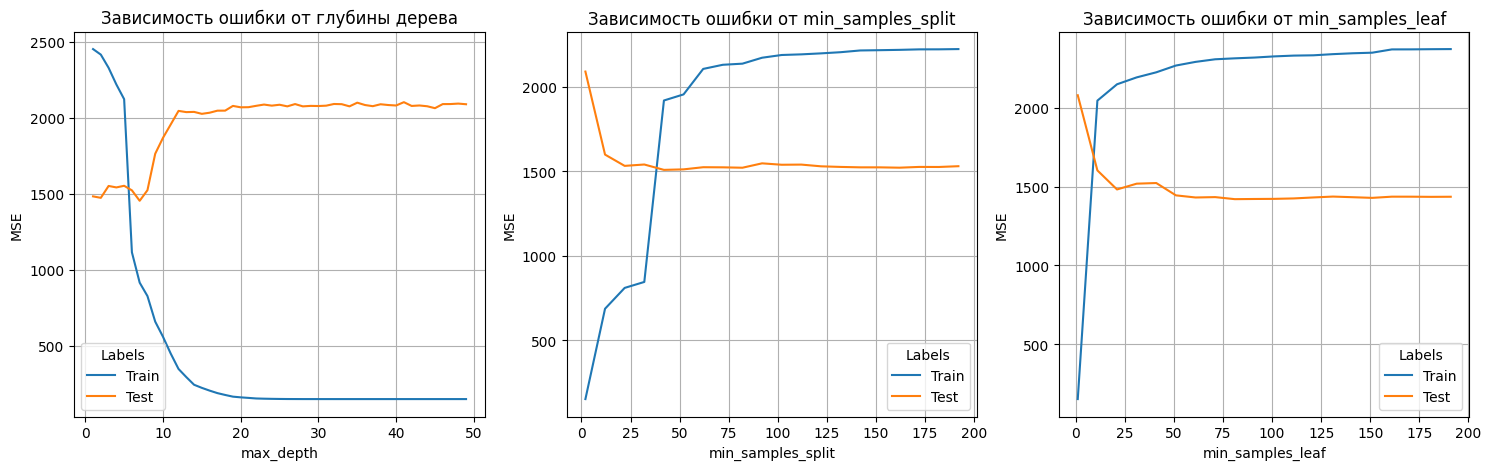

In [ ]:
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
depthes = np.arange(1, 50)
data1 = plot_fitting_curve(DecisionTreeRegressor, 'max_depth', list(depthes) , X_train, X_test, y_train, y_test)
plt.title('Зависимость ошибки от глубины дерева')
plt.grid()

plt.subplot(1, 3, 2)
data2 = plot_fitting_curve(DecisionTreeRegressor, 'min_samples_split', list(np.arange(2, 201, 10)), X_train, X_test, y_train, y_test)
plt.title('Зависимость ошибки от min_samples_split')
plt.grid()

plt.subplot(1, 3, 3)
data3 = plot_fitting_curve(DecisionTreeRegressor, 'min_samples_leaf', list(np.arange(1, 201, 10)), X_train, X_test, y_train, y_test)
plt.title('Зависимость ошибки от min_samples_leaf')
plt.grid()

In [ ]:
# переобучение начинается, когда ошибка на отложеннлй (тестовой) выборке начинает расти.

indx = data1[data1['Labels'] == 'Test'].sort_values(by='MSE').index[0] + 1
data1.loc[indx]

# то есть при глубине дерева 8 и более уже происходит переобучение.

max_depth              8
MSE          1523.280746
Labels              Test
Name: 56, dtype: object

Как видно из графиков выше, при увеличении глубины дерева ошибка на тестовой выборке в какой-то момент начинает увеличиваться и перестает (в среднем) изменяться после этого. То есть при увеличении глубины дерева дальше оно не сможет лучше аппроксимировать нашу зависимость на тестовых данных.

Для `min_samples_split` ошибка на тестовой выборке падает и в какой-то момент выходит на постоянное значение (в среднем). То есть его обобщающая способность уже не может быть лучше даже при увеличении данного параметра ещё больше.Аналогично и для праметра `min_samples_leaf`.

## Linear Regression

Просто ради интереса пребрал все возможные гиперпараметры для модуля LinearRegression.

In [ ]:
lr = LinearRegression(fit_intercept=True)
lr.fit(X_train, y_train)
y_pred_test = lr.predict(X_test)

print(f'Test MSE: {mean_squared_error(y_test, y_pred_test)}')
print(f'Test RMSE: {mean_squared_error(y_test, y_pred_test, squared=False)}')
print(f'R2 score: {r2_score(y_test, y_pred_test)}')

Test MSE: 1428.7963492738445
Test RMSE: 37.79942260503253
R2 score: 0.05047093066011521


In [ ]:
lr = LinearRegression(fit_intercept=False)
lr.fit(X_train, y_train)
y_pred_test = lr.predict(X_test)

print(f'Test MSE: {mean_squared_error(y_test, y_pred_test)}')
print(f'Test RMSE: {mean_squared_error(y_test, y_pred_test, squared=False)}')
print(f'R2 score: {r2_score(y_test, y_pred_test)}')

Test MSE: 1886.2155450038117
Test RMSE: 43.43058306083182
R2 score: -0.25351418481166954


In [ ]:
lr = LinearRegression(positive=True)
lr.fit(X_train, y_train)
y_pred_test = lr.predict(X_test)

print(f'Test MSE: {mean_squared_error(y_test, y_pred_test)}')
print(f'Test RMSE: {mean_squared_error(y_test, y_pred_test, squared=False)}')
print(f'R2 score: {r2_score(y_test, y_pred_test)}')

Test MSE: 1429.5314571600074
Test RMSE: 37.80914515246288
R2 score: 0.049982403161170086


# Простое ансамблирование (1 балл)

В этой секции мы реализуем простой ансамбль деревьев.

In [ ]:
class EnsembleTreeRegressor:
    def __init__(self, num_trees=5, samples_frac=0.8, **model_kwargs):
        self._samples_frac = samples_frac
        self._trees = [DecisionTreeRegressor(**model_kwargs) for _ in range(num_trees)]

    def fit(self, x: pd.DataFrame, y: pd.Series):
        for tree in self._trees:
            tree_x = x.sample(frac=self._samples_frac, random_state=42)
            tree_y = y[tree_x.index]
            tree.fit(tree_x, tree_y)

    def predict(self, x: pd.DataFrame):
        return np.mean([tree.predict(x) for tree in self._trees], axis=0)

Проверьте, работает ли этот ансамбль лучше обычного дерева с параметрами по умолчанию?

Дополнительно переберите максимальную глубину дерева. Проверьте, насколько отличается момент начала переобучения у одиночного дерева и у ансамбля. Зависит ли этот момент от числа деревьев (`num_trees`)? От числа примеров для каждого дерева (`samples_frac`)? Постройте график fitting curve.

In [ ]:
# ансамбль из деревьев с гиперпараметрами по умолчанию

forest = EnsembleTreeRegressor()
forest.fit(pd.DataFrame(X_train), pd.Series(y_train))
y_pred_test = forest.predict(pd.DataFrame(X_test))

print(f'Test MSE: {mean_squared_error(y_test, y_pred_test)}')
print(f'Test RMSE: {mean_squared_error(y_test, y_pred_test, squared=False)}')
print(f'R2 score: {r2_score(y_test, y_pred_test)}')

Test MSE: 1748.1951333652385
Test RMSE: 41.811423479298554
R2 score: -0.16179055108340057


In [ ]:
# одно дерево - это тоже ансамбль, но из одного дерева)
forest = EnsembleTreeRegressor(num_trees=1)
forest.fit(pd.DataFrame(X_train), pd.Series(y_train))
y_pred_test = forest.predict(pd.DataFrame(X_test))

print(f'Test MSE: {mean_squared_error(y_test, y_pred_test)}')
print(f'Test RMSE: {mean_squared_error(y_test, y_pred_test, squared=False)}')
print(f'R2 score: {r2_score(y_test, y_pred_test)}')

Test MSE: 1751.9990120680757
Test RMSE: 41.85688727160771
R2 score: -0.16431847845837066


Видно, что ансамбль с гиперпараметрами по умолчанию работает действительно лучше (хоть и не так сильно), если сравнивать метрики MSE и RMSE, R2 score на тестовой выборке (на всех этих метриках результат оказался лучше, чем для одного дерева)

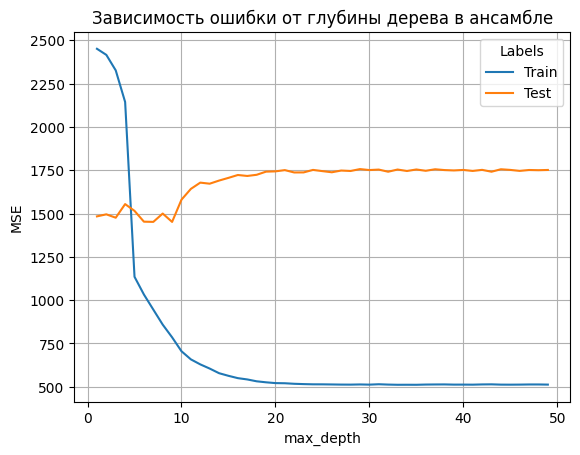

In [ ]:
data_ens = plot_fitting_curve(
    EnsembleTreeRegressor,
    'max_depth',
    list(depthes),
    pd.DataFrame(X_train),
    pd.DataFrame(X_test),
    pd.Series(y_train),
    pd.Series(y_test)
    )

plt.title('Зависимость ошибки от глубины дерева в ансамбле')
plt.grid()
plt.show()

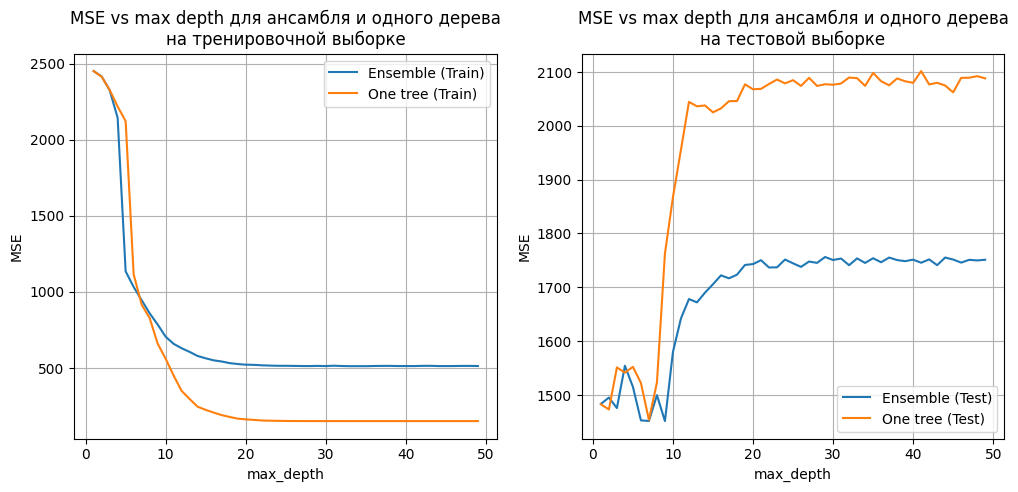

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(depthes, data_ens[data_ens['Labels'] == 'Train']['MSE'], label='Ensemble (Train)')
plt.plot(depthes, data1[data1['Labels'] == 'Train']['MSE'], label='One tree (Train)')
plt.title('MSE vs max depth для ансамбля и одного дерева\nна тренировочной выборке')
plt.xlabel('max_depth')
plt.ylabel('MSE')
plt.grid()
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(depthes, data_ens[data_ens['Labels'] == 'Test']['MSE'], label='Ensemble (Test)')
plt.plot(depthes, data1[data1['Labels'] == 'Test']['MSE'], label='One tree (Test)')
plt.title('MSE vs max depth для ансамбля и одного дерева\nна тестовой выборке')
plt.xlabel('max_depth')
plt.ylabel('MSE')
plt.grid()
plt.legend()

plt.show()

По графику видно, что рост ошибки на тренировочной выборке начинается при разных значениях глубины (8 для одного дерева и 10 для ансамбля). Но скорее всего эти значения сильно зависят от доли, пошедшей в обучающую и тестовую выборки. (Update: если 70% пойдет в тренировочную выборку, то глубины, при которых начнется переобучение будут совпадать).

Будем перебирать различное количество базовых алгоритмов в ансамбле (деревьев), и для каждого различного значения переберем возможные глубины деревьев в ансамбле.

In [ ]:
data_from_forests = []
trees_num = np.arange(1, 20, 3)
for num_trees in trees_num:
    data_ens = plot_fitting_curve(
        EnsembleTreeRegressor,
        'max_depth',
        list(depthes),
        pd.DataFrame(X_train),
        pd.DataFrame(X_test),
        pd.Series(y_train),
        pd.Series(y_test),
        num_trees,
        draw=False
        )
    data_from_forests.append(data_ens)

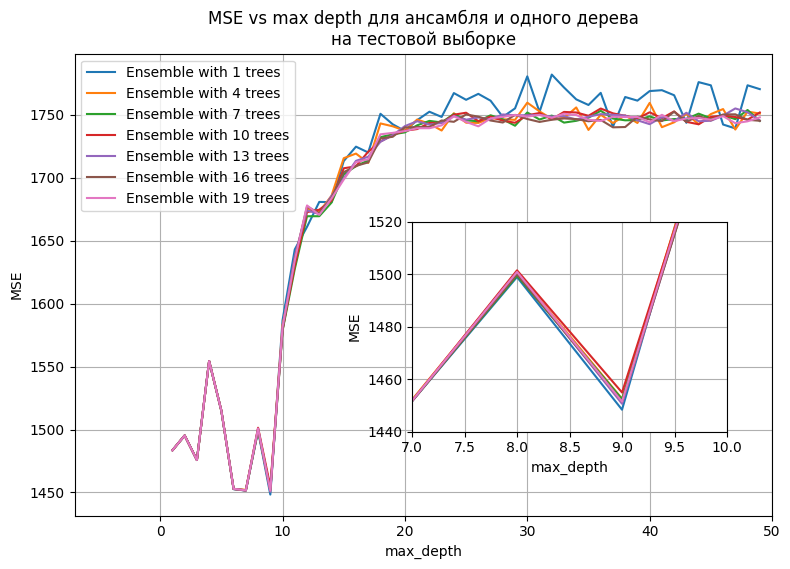

In [ ]:
# very helpful: https://stackoverflow.com/questions/26223937/matplotlib-pandas-zoom-part-of-a-plot-with-time-series/26229669#26229669,
# https://translated.turbopages.org/proxy_u/en-ru.ru.90820a97-6445390c-113e80f5-74722d776562/https/stackoverflow.com/questions/34952752/how-to-zoom-a-part-of-plot-by-matplolib

plt.figure(figsize=(9, 6))
for i, data_ens in enumerate(data_from_forests):
    plt.plot(depthes, data_ens[data_ens['Labels'] == 'Test']['MSE'], label=f'Ensemble with {trees_num[i]} trees')

plt.title('MSE vs max depth для ансамбля и одного дерева\nна тестовой выборке')
plt.xlabel('max_depth')
plt.ylabel('MSE')
plt.grid()
plt.xlim(-7, 50)
plt.legend(fontsize=10, loc='upper left')

# построение увеличенной части графика
plt.axes([.5, .25, .35, .35])
for i, data_ens in enumerate(data_from_forests):
    plt.plot(depthes, data_ens[data_ens['Labels'] == 'Test']['MSE'])
    plt.xlim(7, 10)
    plt.ylim(1440, 1520)
    plt.xlabel('max_depth')
    plt.ylabel('MSE')
    plt.grid()

plt.show()

На подграфике нарисована увеличенная часть около минимума и видно, что переобучение начинается у весх ансамблей одинаково вне зависимости от количества деревьев.

Тперь отдельно посмотрим на ошибки при различных количествах базовых алгоритмов для дефолтных параметров каждого дерева.

In [ ]:
trees_num = np.arange(1, 100, 3)

data_ens = plot_fitting_curve(
    EnsembleTreeRegressor,
    'num_trees',
    list(trees_num),
    pd.DataFrame(X_train),
    pd.DataFrame(X_test),
    pd.Series(y_train),
    pd.Series(y_test),
    draw=False
    )

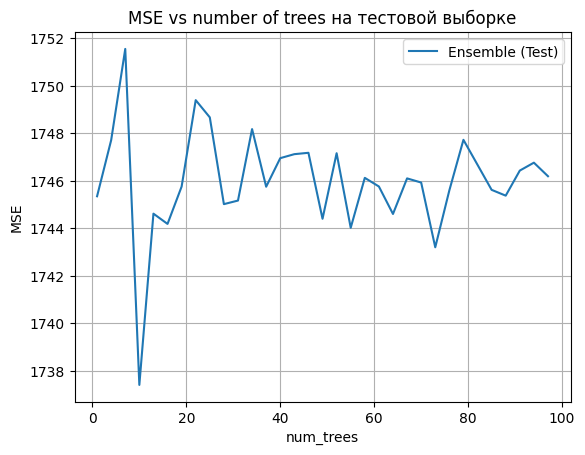

In [ ]:
plt.plot(trees_num, data_ens[data_ens['Labels'] == 'Test']['MSE'], label='Ensemble (Test)')
plt.title('MSE vs number of trees на тестовой выборке')
plt.xlabel('num_trees')
plt.ylabel('MSE')
plt.grid()
plt.legend()
# plt.xlim(0, 25)
plt.show()

Из графика, получаем что минимальное значение ошибки достигается при 10 деервьях (при дефолтных параметрах для каждого из них), дальше происходит рост ошибки и в среднем её значение ввыше этого минимума.

In [ ]:
samples_frac = np.linspace(0, 1, 100)[1:]

data_ens = plot_fitting_curve(
    EnsembleTreeRegressor,
    'samples_frac',
    list(samples_frac),
    pd.DataFrame(X_train),
    pd.DataFrame(X_test),
    pd.Series(y_train),
    pd.Series(y_test),
    draw=False
    )

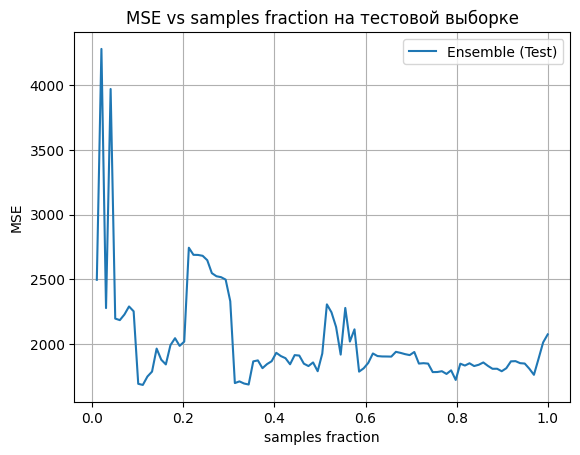

In [ ]:
plt.plot(samples_frac, data_ens[data_ens['Labels'] == 'Test']['MSE'], label='Ensemble (Test)')
plt.title('MSE vs samples fraction на тестовой выборке')
plt.xlabel('samples fraction')
plt.ylabel('MSE')
plt.grid()
plt.legend()
# plt.xlim(0, .12)
plt.show()

In [ ]:
c = data_ens[data_ens['Labels'] == 'Test']
c[c['MSE'] == c['MSE'].min()]

,samples_frac,MSE,Labels
109,0.111111,1683.422361,Test


А тут уже получается, что минимальное значение ошибки достигается при доле равной 0.101, хотя потом происходят всплески ошибки; скорее всего это связано с тем, что слишком малая доля данных пошла на тренировку и в тестовых данных поэтому слишком много того, что деревья 'не видели'.

Таким образом, при увеличении числа деревьев или уменьшении количества примеров для каждого дерева, ансамбль становится менее склонным к переобучению. Однако, при увеличении максимальной глубины деревьев, начало переобучения может происходить раньше.

мем для проверяющего 🙃:
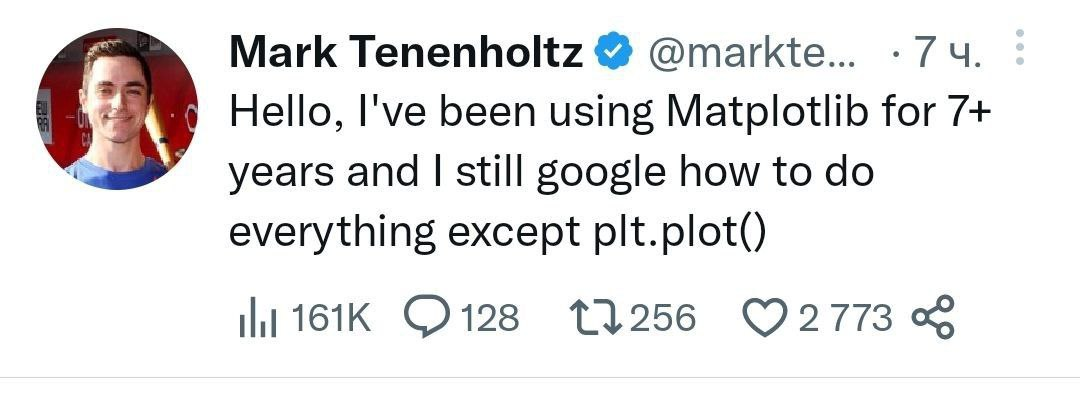
